<a href="https://colab.research.google.com/github/RonBartov/MLEM_Iterative_Image_Reconstruiction/blob/main/iterative_radon_image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## **Import Test Image- Shepp Logan Phantom**
The Shepp–Logan phantom is a standard test image created by Larry Shepp and Benjamin F. Logan for their 1974 paper The Fourier Reconstruction of a Head Section.
This image serves as the model of a human head in the development and testing of image reconstruction algorithms

In [2]:
activity_level = 0.1 ; # normalizing factor for the image pixels
true_object = shepp_logan_phantom() ; # 400 x 400
true_object = rescale(activity_level * true_object,0.5) ; # 200 x 200

## **Creating main plots grid**

Text(0.5, 1.0, 'Object')

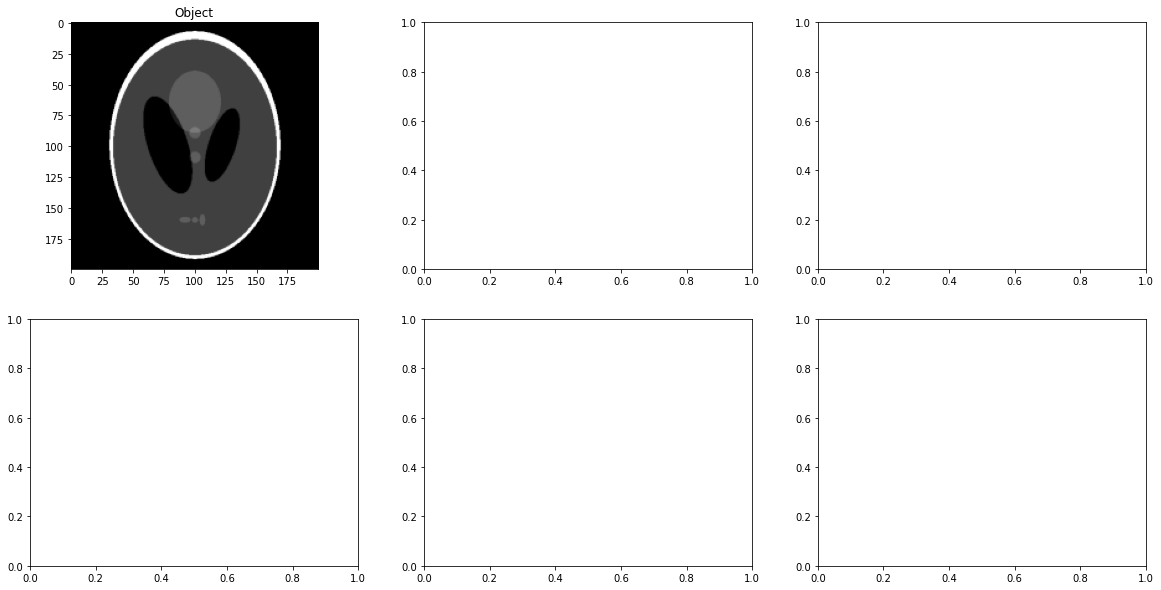

In [3]:
fig, axs = plt.subplots(2,3,figsize=(20,10)) ; # figsize in inches
axs[0,0].imshow(true_object,cmap='Greys_r') ; axs[0,0].set_title('Object')

## **Genarating Sinogram**

Sinogram is the result obtains by projecting the true image in different angles. We can achieve the sinogram by using the Radon transformation

In [4]:
azi_angles = np.linspace(0.0,180.0,180, endpoint=False) ; # angels for projecting 
sinogram = radon(true_object, azi_angles, circle=False) ;

In [6]:
print(azi_angles) ;

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.]


In [7]:
axs[0,1].imshow(sinogram.T, cmap='Greys_r') ; axs[0,1].set_title('Sinogram') ;

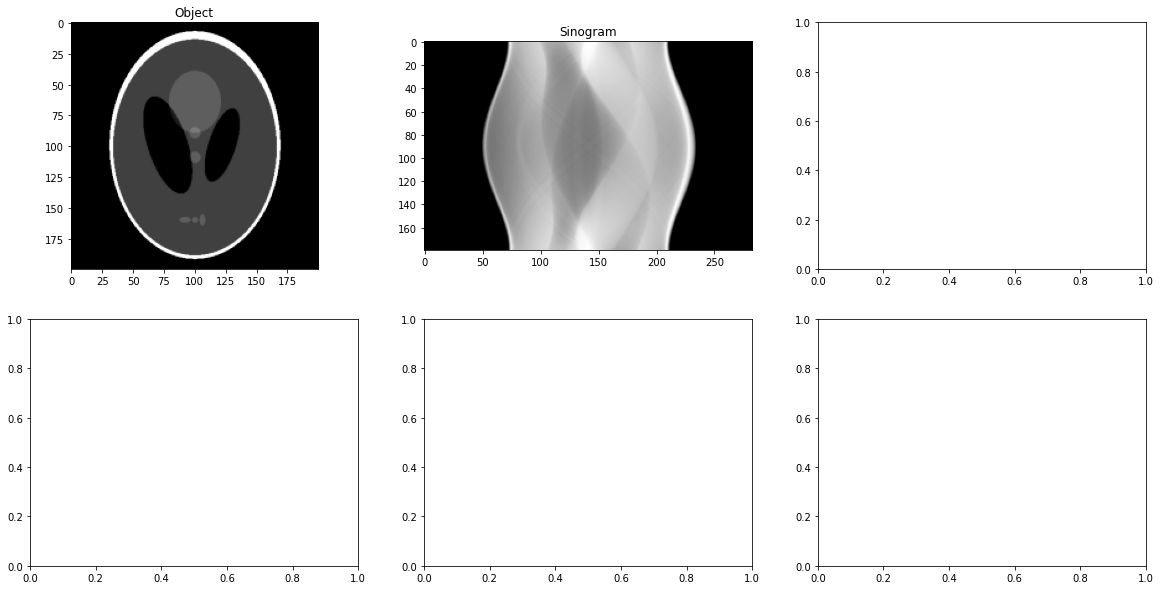

In [8]:
fig # show plots grid

## **MLEM Iterative Algotrithm**
Radon is a linear transformation which can be described as a matrix multiplication:

$R(x) = A*x$

We consider the problem of finding the values for an unknown image $x\in R^{n}$
Given the system matrix $A\in R^{m\cdot n}$ and the observations $m\in R^{m}$ 


We can solve the problem by using maximum likelihood estimation, where $x\ge0$ due to the image properties, which will lead us to the following MLEM iterative algorithm:


$x^{k+1} = \frac{x^{k}}{A^{T} \cdot 1}*A^T*\frac{m}{A*x^{k}}$


In [9]:
mlem_rec = np.ones(true_object.shape) ; # 200 x 200, iteration k=0, mlem_rec = x^k

In [12]:
print('mlem_rec size: ', np.shape(mlem_rec)) ;
print('mlem_rec matrix for k=0: ')
print(mlem_rec) ;

mlem_rec size:  (200, 200)
mlem_rec matrix for k=0: 
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [13]:
fp = radon(mlem_rec,azi_angles,circle=False) # Forward projection of mlem_rec, Ax^k 

In [14]:
ratio = sinogram / (fp + 0.000001) ; # 0.000001 in order to avoid devide by zero, m/(Ax^k)

In [15]:
sino_ones = np.ones(sinogram.shape) ; # 1's matrix 

In [16]:
sens_image = iradon(sino_ones,azi_angles,circle=False,filter_name=None) ; # A^T*1

In [17]:
correction = iradon(ratio,azi_angles, circle=False,filter_name=None) / sens_image ; # (A^T/A^T1)*(m/(Ax^k)), all algorithm blocks are ready except multiplication of x^k (mlem_rec)

In [18]:
axs[1,1].imshow(fp.T,cmap='Greys_r') ; axs[1,1].set_title('Forward Proj of Reconst')
axs[0,2].imshow(ratio.T,cmap='Greys_r') ; axs[0,2].set_title('Ratio Sinogram')
axs[1,0].imshow(mlem_rec,cmap='Greys_r') ; axs[1,0].set_title('MLEM Reconstruct Image')
axs[1,2].imshow(correction,cmap='Greys_r') ; axs[1,2].set_title('Back Proj of Sinogram')

Text(0.5, 1.0, 'Back Proj of Sinogram')

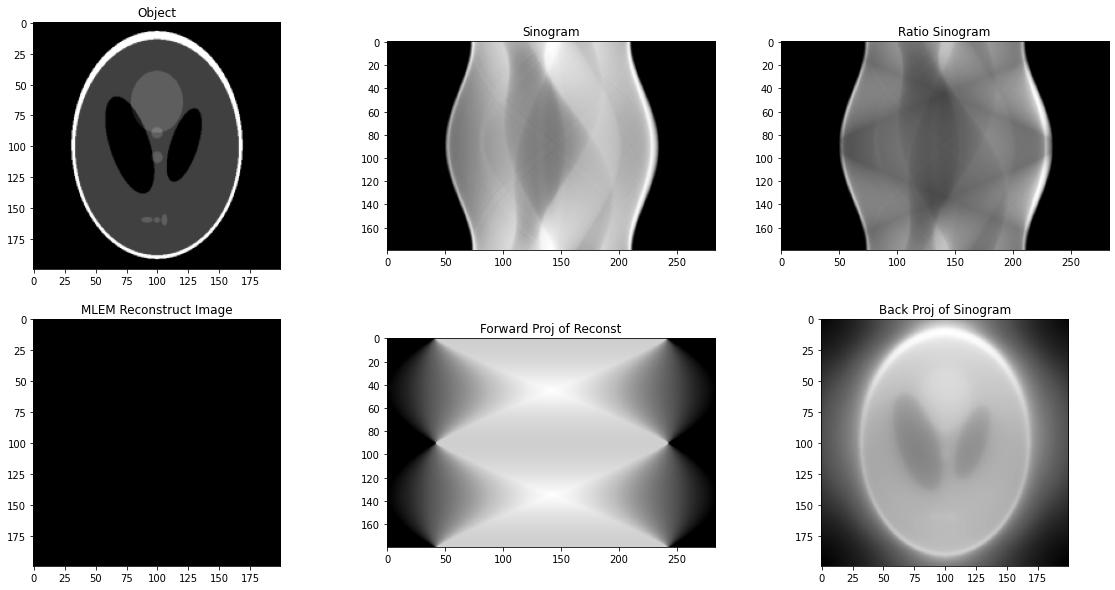

In [19]:
fig

## **Iterative Loop**

In [20]:
num_of_iter = 10 ;

In [21]:
for iter in range(num_of_iter):
  mlem_rec = mlem_rec * correction ;
  fp = radon(mlem_rec,azi_angles,circle=False) ; # Forward projection of mlem_rec, Ax^k
  ratio = sinogram / (fp + 0.000001) ; # 0.000001 in order to avoid devide by zero, m/(Ax^k)
  sino_ones = np.ones(sinogram.shape) ; # 1's matrix 
  sens_image = iradon(sino_ones,azi_angles,circle=False,filter_name=None) ; # A^T*1
  correction = iradon(ratio,azi_angles, circle=False,filter_name=None) / sens_image ; # (A^T/A^T1)*(m/(Ax^k)), all algorithm blocks are ready except multiplication of x^k (mlem_rec)

## **Final Results**

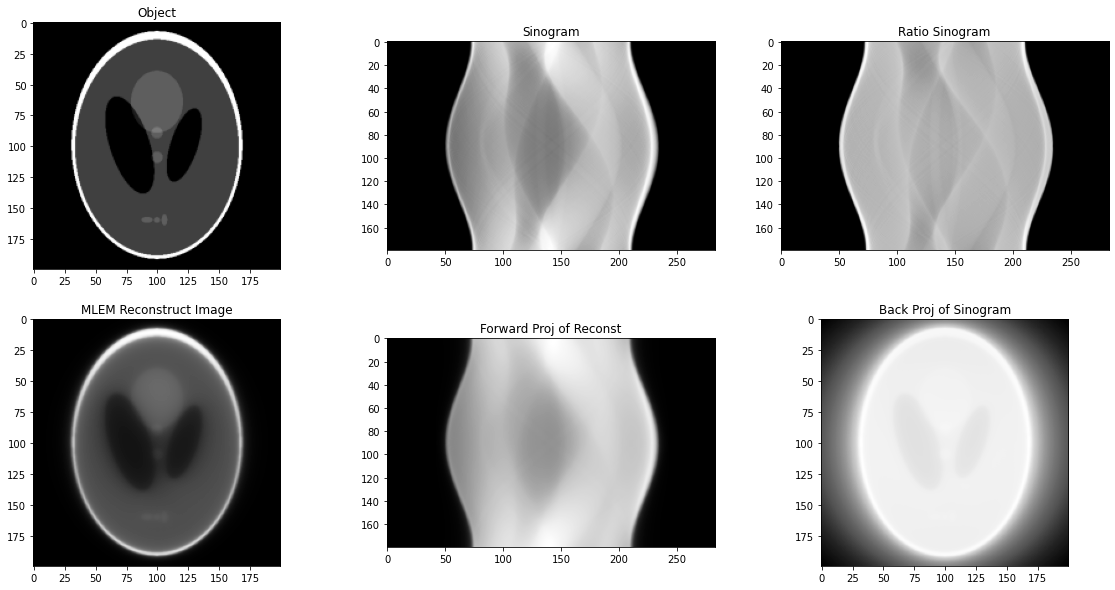

In [22]:
axs[1,1].imshow(fp.T,cmap='Greys_r') ; axs[1,1].set_title('Forward Proj of Reconst')
axs[0,2].imshow(ratio.T,cmap='Greys_r') ; axs[0,2].set_title('Ratio Sinogram')
axs[1,0].imshow(mlem_rec,cmap='Greys_r') ; axs[1,0].set_title('MLEM Reconstruct Image')
axs[1,2].imshow(correction,cmap='Greys_r') ; axs[1,2].set_title('Back Proj of Sinogram')
fig